In [29]:
import numpy as np
import pandas as pd

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick # For specifying the axes tick format 

import seaborn as sns
import re

import json, os, gc, math, time
import datetime
import collections
from tqdm import tqdm
import glob

from statistics import mean
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

from sklearn import metrics

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#ドライブへのアクセス
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/00_datascience/19_ufj_bank"

Mounted at /content/drive
/content/drive/My Drive/00_datascience/19_ufj_bank


In [ ]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sub = pd.read_csv('input/sample_submit.csv')

In [ ]:
train.head()

,id,goal,country,duration,category1,category2,html_content,state
0,train_00000,20001-21000,US,45,art,mixed media,"<div class=""contents""><div><p><a href=""http://dummy.com"">http://dummy.com<p>In its first year, The Shillito's Elves Display won an international \ndesign award for Shillito's department store. The elves display is arts\n and crafts at its finest. The mixed media exhibit displays the talents\n of local fine arts graduates, and the display, while ""folksy"", is as \ntechnologically advanced as Disney World's famous ""It's a Small World"" \nride. </p><p>The Shillito's Elves attracted close to 100...",1
1,train_00001,19001-20000,US,59,food,restaurants,"<div class=""contents""><div><p>Cultural Pretzel Sports Bar is a place where people can come and watch their favorite local and world wide sports teams, while enjoying their favorite ethnic foods on a soft pretzel. Our menu includes a variety of appetizers and soft pretzels. Our pretzels include - Mexican Taco, Mexican Steak Fajita, Greek Gyro, Italian Sausage and Peppers, and American Steak Philly Soft Pretzels. With more to be added to the menu as the business grows.</p><p>Cultural Pretze...",0
2,train_00002,2001-3000,US,38,art,performance art,"<div class=""contents""><div><p>I want to perform this piece guerilla style, off the back off a 24 Ft truck on Christmas Eve, amid last minute Christmas shopping in New York City.</p>\n<p>Our truck pulls in, the door rolls up and I perform. </p>\n<p>New York is a city where you just do it - no excuses. A place where the new becomes the normal real fast and where the artist is challenged to capture the attention and the hearts of the unshockable and unstoppable. In times of celebration and re...",0
3,train_00003,1001-2000,US,30,art,mixed media,"<div class=""contents""><div><div class=""template asset"" contenteditable=""false"" data-alt-text="""" data-caption="""" data-id=""_xxx_"">\n<figure>\n<img alt="""" class=""fit lazyload"" data-src=""http://dummy.com""/>\n</figure>\n</div>\n<h1 class=""page-anchor"" id=""_xxx_"">\n<figure>\n<img alt=""Canyon de Chelley, Dine' (Navajo) Reservation, Arizona. Photo by: Demian Dine' Yazhi'"" class=""fit lazyload"" data-src=""http://dummy.com""/>\n<figcaption class=""px2"">Canyon de Chelley, Dine' (Navajo) Reservation, Arizo...",1
4,train_00004,1001-2000,US,29,film & video,webseries,"<div class=""contents""><div><p>The story of the show, both on and off screen, is about daring to dream after something impossible.Even with an incredible amount of difficulty and opposition, the project continued to grow in size and depth. A year ago, we were finally able to release the pilot episode of Azusa Ghost Hunter's Society (check it out! <a href=""http://dummy.com"">\n<figure>\n<img alt="""" class=""fit lazyload"" data-src=""http://dummy.com""/>\n</figure>\n</div>\n<p>Which brings us to now...",1


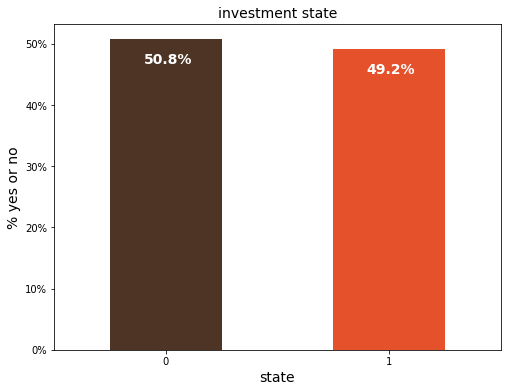

In [9]:
colors = ['#4D3425','#E4512B']
ax = (train['state'].value_counts()*100.0 /len(train)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% yes or no',size = 14)
ax.set_xlabel('state',size = 14)
ax.set_title('investment state', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold',
           size = 14)

In [11]:
from matplotlib_venn import venn2
def plot_venn_train_test(tra, val, col):
    """trainとtestのベン図をplotする
    """
    fig, ax = plt.subplots(figsize=(6,9))
    plt.title(col, fontsize=10)
    train_unique = tra[col].unique()
    test_unique = val[col].unique()
    common_num = len(set(train_unique) & set(test_unique))
    venn2(subsets=(len(train_unique)-common_num, len(test_unique)-common_num, common_num),set_labels=('train', 'test'))
    return fig, ax

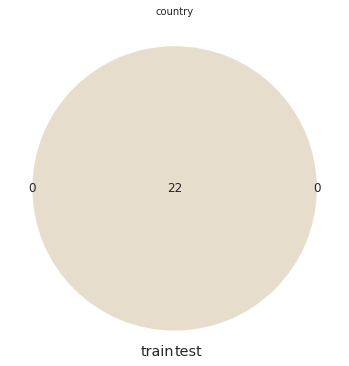

In [12]:
#idの被りの確認
fig, ax = plot_venn_train_test(train, test, "country")

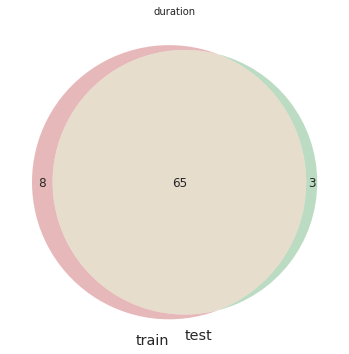

In [13]:
#idの被りの確認
fig, ax = plot_venn_train_test(train, test, "duration")

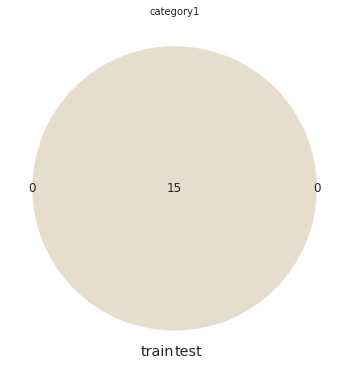

In [14]:
#category1の被りの確認
fig, ax = plot_venn_train_test(train, test, "category1")

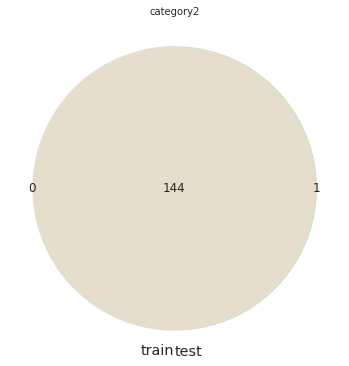

In [15]:
#category2の被りの確認
fig, ax = plot_venn_train_test(train, test, "category2")

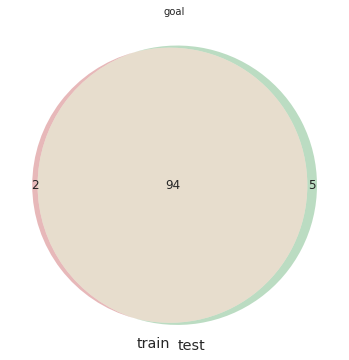

In [16]:
#goalの被りの確認
fig, ax = plot_venn_train_test(train, test, "goal")

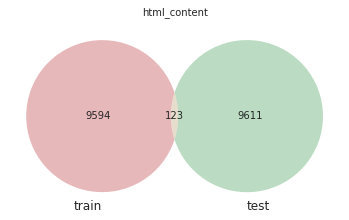

In [39]:
#goalの被りの確認
fig, ax = plot_venn_train_test(train, test, "html_content")

In [43]:
train['html_content'].unique == test['html_content'].unique

ValueError: ignored

In [19]:
print('---------------- train_data ----------------')
print(train['goal'].unique())
print('---------------- test_data ----------------')
print(test['goal'].unique())

---------------- train_data ----------------
['20001-21000' '19001-20000' '2001-3000' '1001-2000' '4001-5000' '1-1000'
 '13001-14000' '34001-35000' '15001-16000' '3001-4000' '11001-12000'
 '12001-13000' '5001-6000' '100000+' '7001-8000' '9001-10000'
 '29001-30000' '6001-7000' '40001-41000' '54001-55000' '22001-23000'
 '52001-53000' '32001-33000' '17001-18000' '49001-50000' '14001-15000'
 '24001-25000' '10001-11000' '21001-22000' '44001-45000' '8001-9000'
 '28001-29000' '99001-100000' '30001-31000' '18001-19000' '55001-56000'
 '16001-17000' '64001-65000' '67001-68000' '60001-61000' '89001-90000'
 '31001-32000' '85001-86000' '36001-37000' '27001-28000' '38001-39000'
 '83001-84000' '97001-98000' '78001-79000' '69001-70000' '35001-36000'
 '23001-24000' '74001-75000' '59001-60000' '26001-27000' '63001-64000'
 '79001-80000' '48001-49000' '41001-42000' '39001-40000' '45001-46000'
 '56001-57000' '33001-34000' '25001-26000' '57001-58000' '88001-89000'
 '47001-48000' '96001-97000' '94001-95000' 

In [20]:
train.head()

,id,goal,country,duration,category1,category2,html_content,state
0,train_00000,20001-21000,US,45,art,mixed media,"<div class=""contents""><div><p><a href=""http://dummy.com"">http://dummy.com<p>In its first year, The Shillito's Elves Display won an international \ndesign award for Shillito's department store. The elves display is arts\n and crafts at its finest. The mixed media exhibit displays the talents\n of local fine arts graduates, and the display, while ""folksy"", is as \ntechnologically advanced as Disney World's famous ""It's a Small World"" \nride. </p><p>The Shillito's Elves attracted close to 100...",1
1,train_00001,19001-20000,US,59,food,restaurants,"<div class=""contents""><div><p>Cultural Pretzel Sports Bar is a place where people can come and watch their favorite local and world wide sports teams, while enjoying their favorite ethnic foods on a soft pretzel. Our menu includes a variety of appetizers and soft pretzels. Our pretzels include - Mexican Taco, Mexican Steak Fajita, Greek Gyro, Italian Sausage and Peppers, and American Steak Philly Soft Pretzels. With more to be added to the menu as the business grows.</p><p>Cultural Pretze...",0
2,train_00002,2001-3000,US,38,art,performance art,"<div class=""contents""><div><p>I want to perform this piece guerilla style, off the back off a 24 Ft truck on Christmas Eve, amid last minute Christmas shopping in New York City.</p>\n<p>Our truck pulls in, the door rolls up and I perform. </p>\n<p>New York is a city where you just do it - no excuses. A place where the new becomes the normal real fast and where the artist is challenged to capture the attention and the hearts of the unshockable and unstoppable. In times of celebration and re...",0
3,train_00003,1001-2000,US,30,art,mixed media,"<div class=""contents""><div><div class=""template asset"" contenteditable=""false"" data-alt-text="""" data-caption="""" data-id=""_xxx_"">\n<figure>\n<img alt="""" class=""fit lazyload"" data-src=""http://dummy.com""/>\n</figure>\n</div>\n<h1 class=""page-anchor"" id=""_xxx_"">\n<figure>\n<img alt=""Canyon de Chelley, Dine' (Navajo) Reservation, Arizona. Photo by: Demian Dine' Yazhi'"" class=""fit lazyload"" data-src=""http://dummy.com""/>\n<figcaption class=""px2"">Canyon de Chelley, Dine' (Navajo) Reservation, Arizo...",1
4,train_00004,1001-2000,US,29,film & video,webseries,"<div class=""contents""><div><p>The story of the show, both on and off screen, is about daring to dream after something impossible.Even with an incredible amount of difficulty and opposition, the project continued to grow in size and depth. A year ago, we were finally able to release the pilot episode of Azusa Ghost Hunter's Society (check it out! <a href=""http://dummy.com"">\n<figure>\n<img alt="""" class=""fit lazyload"" data-src=""http://dummy.com""/>\n</figure>\n</div>\n<p>Which brings us to now...",1


In [21]:
print('---------------- train_data ----------------')
print(train['country'].unique())
print('---------------- test_data ----------------')
print(test['country'].unique())

---------------- train_data ----------------
['US' 'CA' 'FR' 'GB' 'IT' 'AU' 'DE' 'SE' 'NO' 'DK' 'SG' 'BE' 'ES' 'MX'
 'AT' 'NL' 'NZ' 'HK' 'CH' 'IE' 'JP' 'LU']
---------------- test_data ----------------
['FR' 'GB' 'CA' 'US' 'DE' 'HK' 'AU' 'IE' 'NO' 'IT' 'MX' 'DK' 'NZ' 'NL'
 'ES' 'SE' 'BE' 'JP' 'SG' 'CH' 'AT' 'LU']


In [22]:
print('---------------- train_data ----------------')
print(train['duration'].unique())
print('---------------- test_data ----------------')
print(test['duration'].unique())

---------------- train_data ----------------
[45 59 38 30 29 31 15 35 40 28 20 22 84 14 26  7 49 32 43 50 44 27 42 60
 37 36 57 55 24 54 11 33 21 25 46 41  9 18 13 17 19 58 10 23 39  6 51 16
 52 34 72 56 48  8  5  1 53  4  2 86 90 12 89  3 74 47 85 70 80 61 76 81
 71]
---------------- test_data ----------------
[30 23 14 45 43 40 60 28 15 16 44 33 29 21 35 20 41 22 52 18 59 39 25 32
 13 42 56 19 11 27 26 31  3 51 53 34  7 37  8 36 12 46 17 57 10 49  4 50
 58 47 48  9  2 24 38  1 54 55  6  5 89 70 88 76 62 63 84 72]


In [26]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(train[train['state'] == 0][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(train[train['state'] == 1][feature].dropna(), color= 'orange', label= 'Churn: Yes')

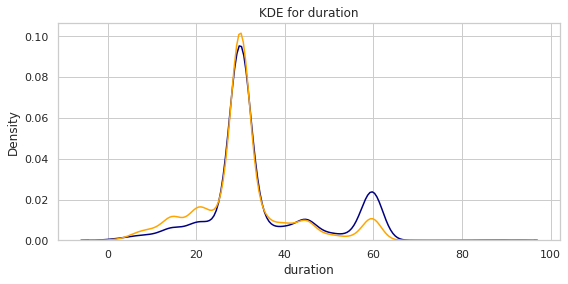

In [27]:
num_cols = 'duration'
kdeplot(num_cols)

In [30]:
print('---------------- train_data ----------------')
print(train['category1'].unique())
print('---------------- test_data ----------------')
print(test['category1'].unique())

---------------- train_data ----------------
['art' 'food' 'film & video' 'theater' 'music' 'technology' 'fashion'
 'publishing' 'journalism' 'games' 'design' 'photography' 'comics'
 'crafts' 'dance']
---------------- test_data ----------------
['dance' 'publishing' 'theater' 'art' 'music' 'technology' 'film & video'
 'fashion' 'food' 'design' 'games' 'journalism' 'crafts' 'photography'
 'comics']


In [31]:
print('---------------- train_data ----------------')
print(train['category2'].unique())
print('---------------- test_data ----------------')
print(test['category2'].unique())

---------------- train_data ----------------
['mixed media' 'restaurants' 'performance art' 'webseries' 'plays'
 'classical music' 'public art' 'metal' 'country & folk' 'diy electronics'
 'footwear' 'art books' 'accessories' 'calendars' 'digital art' 'web'
 'drinks' 'fiction' 'world music' 'mobile games' 'food trucks' 'musical'
 'illustration' 'narrative film' 'shorts' 'architecture' 'movie theaters'
 'fine art' "children's books" 'hardware' 'animals' 'playing cards'
 'graphic novels' 'radio & podcasts' 'animation' 'festivals' 'hip-hop'
 'print' 'webcomics' 'gadgets' 'people' 'diy' 'electronic music'
 'live games' 'installations' 'thrillers' 'farms' 'spaces' 'events' 'rock'
 'jewelry' 'software' 'woodworking' 'science fiction' 'poetry' 'places'
 'bacon' 'community gardens' 'young adult' 'family' 'fantasy' 'painting'
 'comedy' 'gaming hardware' 'jazz' 'nonfiction' 'performances'
 '3d printing' 'graphic design' 'small batch' 'vegan' 'photobooks'
 "farmer's markets" 'horror' 'couture' 'ta

In [28]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [36]:
for i in range(len(train)):
  train.loc[i, 'cleaned_text'] = remove_html(train.loc[i, 'html_content'])

In [47]:
train.head()

,id,goal,country,duration,category1,category2,html_content,state,cleaned_text
0,train_00000,20001-21000,US,45,art,mixed media,"<div class=""contents""><div><p><a href=""http://dummy.com"">http://dummy.com<p>In its first year, The Shillito's Elves Display won an international \ndesign award for Shillito's department store. The elves display is arts\n and crafts at its finest. The mixed media exhibit displays the talents\n of local fine arts graduates, and the display, while ""folksy"", is as \ntechnologically advanced as Disney World's famous ""It's a Small World"" \nride. </p><p>The Shillito's Elves attracted close to 100...",1,"http://dummy.comIn its first year, The Shillito's Elves Display won an international \ndesign award for Shillito's department store. The elves display is arts\n and crafts at its finest. The mixed media exhibit displays the talents\n of local fine arts graduates, and the display, while ""folksy"", is as \ntechnologically advanced as Disney World's famous ""It's a Small World"" \nride. The Shillito's Elves attracted close to 100,000 people each\n year. It was one of the most beloved Christmas ..."
1,train_00001,19001-20000,US,59,food,restaurants,"<div class=""contents""><div><p>Cultural Pretzel Sports Bar is a place where people can come and watch their favorite local and world wide sports teams, while enjoying their favorite ethnic foods on a soft pretzel. Our menu includes a variety of appetizers and soft pretzels. Our pretzels include - Mexican Taco, Mexican Steak Fajita, Greek Gyro, Italian Sausage and Peppers, and American Steak Philly Soft Pretzels. With more to be added to the menu as the business grows.</p><p>Cultural Pretze...",0,"Cultural Pretzel Sports Bar is a place where people can come and watch their favorite local and world wide sports teams, while enjoying their favorite ethnic foods on a soft pretzel. Our menu includes a variety of appetizers and soft pretzels. Our pretzels include - Mexican Taco, Mexican Steak Fajita, Greek Gyro, Italian Sausage and Peppers, and American Steak Philly Soft Pretzels. With more to be added to the menu as the business grows.Cultural Pretzel plans to start with one Sports Bar ..."
2,train_00002,2001-3000,US,38,art,performance art,"<div class=""contents""><div><p>I want to perform this piece guerilla style, off the back off a 24 Ft truck on Christmas Eve, amid last minute Christmas shopping in New York City.</p>\n<p>Our truck pulls in, the door rolls up and I perform. </p>\n<p>New York is a city where you just do it - no excuses. A place where the new becomes the normal real fast and where the artist is challenged to capture the attention and the hearts of the unshockable and unstoppable. In times of celebration and re...",0,"I want to perform this piece guerilla style, off the back off a 24 Ft truck on Christmas Eve, amid last minute Christmas shopping in New York City.\nOur truck pulls in, the door rolls up and I perform. \nNew York is a city where you just do it - no excuses. A place where the new becomes the normal real fast and where the artist is challenged to capture the attention and the hearts of the unshockable and unstoppable. In times of celebration and rest our intellectual faculties are more easil..."
3,train_00003,1001-2000,US,30,art,mixed media,"<div class=""contents""><div><div class=""template asset"" contenteditable=""false"" data-alt-text="""" data-caption="""" data-id=""_xxx_"">\n<figure>\n<img alt="""" class=""fit lazyload"" data-src=""http://dummy.com""/>\n</figure>\n</div>\n<h1 class=""page-anchor"" id=""_xxx_"">\n<figure>\n<img alt=""Canyon de Chelley, Dine' (Navajo) Reservation, Arizona. Photo by: Demian Dine' Yazhi'"" class=""fit lazyload"" data-src=""http://dummy.com""/>\n<figcaption class=""px2"">Canyon de Chelley, Dine' (Navajo) Reservation, Arizo...",1,"\n\n\n\n\n\n\n\nCanyon de Chelley, Dine' (Navajo) Reservation, Arizona. Photo by: Demian Dine' Yazhi'\n\n\nAnother goal of the project is to actively document the process throu